# Semantic Segmentation with PyTorch and U-Net

**Author:** Shingo Nakazawa ([@shnakazawa](https://twitter.com/shnakazawa))

**Objective:** This series of notebooks provides baseline codes for Computer Vision (CV) Tasks. The target readers are those who want to try CV competitions and those who want to learn CV methods that can be applied to their duties.

This notebook is the third section of the following:

1. [Image Classification with PyTorch and EfficientNetV2](https://github.com/shnakazawa/computer-vision-baselines/blob/main/1_Classification_PyTorch_EfficientNetV2.ipynb)
1. [Object Detection with PyTorch and DETR](https://github.com/shnakazawa/computer-vision-baselines/blob/main/2_Object_Detection_PyTorch_DETR.ipynb)
1. **Semantic Segmentation with PyTorch and U-Net**

In this notebook, we will create a semantic segmentation model using the [**U-Net architecture**](https://arxiv.org/abs/1505.04597).

U-Net is specifically designed for image segmentation tasks, which involve identifying different objects or regions within an image and labeling them with different classes. In this notebook, we will implement the U-Net architecture using [**PyTorch**](https://pytorch.org/), **without relying on pre-existing implementations or models**.

Please see also [[a reference article (Japanese)](https://zenn.dev/aidemy/articles/a43ebe82dfbb8b)]

## Dataset

Here, the dataset of [Kaggle Sartorius - Cell Instance Segmentation competition](https://www.kaggle.com/competitions/sartorius-cell-instance-segmentation/overview) is used.

**[You can directly run this notebook on Kaggle.](https://www.kaggle.com/code/shnakazawa/semantic-segmentation-with-pytorch-and-u-net)**

Alternatively, you can download the dataset and place it as shown below.

```zsh
.
├── This notebook
└── data/
    └── sartorius-cell-instance-segmentation/
        ├── train.csv
        ├── train/
        ├── test/
        etc...
```

## Import Modules

In [1]:
import os
import numpy as np
import pandas as pd
import math
import time
import random
import gc
from pathlib import Path
import cv2
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold

# Image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

print(f'PyTorch version {torch.__version__}')
print(f'Albumentations version {A.__version__}')

PyTorch version 1.13.0
Albumentations version 1.3.0


## Set Configs

Separately configuring settings such as objectives for running, file paths, hyperparameters, and other parameters can greatly aid in maintaining a clear and organized workflow.

In [2]:
KAGGLE = True # True if runnning on Kaggle Notebook. False if else.
RUN_EDA = True
RUN_TRAINING = True
TRAIN_ALL = False # If true, train with all data and output a single model. If False, run cross-validation and output multiple models.
FOLD_NUM = 5 # For cross-validation
EPOCHS = 20 # Training cycle
RUN_INFERENCE = False

# Directory setting
if KAGGLE:
    DATA_DIR = '/kaggle/input/sartorius-cell-instance-segmentation/'
    MODEL_DIR = '/kaggle/working/'
    IMG_SAVE_DIR = '/kaggle/working/'
else:
    DATA_DIR = 'data/sartorius-cell-instance-segmentation/'
    MODEL_DIR = 'models/sartorius-cell-instance-segmentation/'
    CSV_SAVE_DIR = 'outputs/sartorius-cell-instance-segmentation/csv/'
    IMG_SAVE_DIR = 'outputs/sartorius-cell-instance-segmentation/img/'

# PyTorch variables
LOCAL_DEVICE = 'cpu' # 'cuda', 'cpu', or 'mps'. Depends on your PC. Is used only when KAGGLE = False.
SEED = 42
NUM_WORKERS = 2
BATCH_SIZE = 8
WEIGHT_DECAY = 0.0001
LR = 0.0001
MOMENTUM = 0.9

# Threshold for mask prediction
THRESHOLD = 0.3

# Set device
if KAGGLE:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
else:
    device = LOCAL_DEVICE
print(f'Using {device} device')

Using cuda device


## Define Helper Functions

Defining reusable functions at the beginning of a Jupyter Notebook can result in code that is cleaner, more organized, and more efficient.

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Set seed
seed_everything(SEED)


def show_gpu_memory(device):
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024 / 1024:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_cached(device) / 1024 / 1024:.2f} MB")    

    
def load_img(path):
    img_bgr = cv2.imread(path)
    img_rgb = img_bgr[:, :, ::-1]
    return img_rgb


def group_bboxes(df):
    df_ = df.copy()
    df_['segment_count'] = 1
    df_ = df_.groupby(['id', 'width', 'height', 'cell_type']).count().reset_index()
    return_df = df_[['id', 'width', 'height', 'cell_type', 'segment_count']]
    return return_df


def create_gallery(array, ncols=3):
    """Display multiple images in a gallery style.
    Source: https://www.amazon.co.jp/Data-Analysis-Machine-Learning-Kaggle-ebook/dp/B09F3STL34/
    
    Args:
        array (numpy.ndarray): array of images.
        ncols (int, optional): Num of columns. Defaults to 3.

    Returns:
        numpy.ndarray: One concatenated image.
    """    
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows * ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
        .swapaxes(1,2)
        .reshape(height*nrows, width*ncols, intensity))
    return result


def decode_rle(rle, height, width):
    """RLE to image
    modified from: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

    Args:
        rle (str): mask with run length encoding.
        height (int): return image height.
        width (int): return image width.
        brightness (int): brightness of the pixel. Default to 1.

    Returns:
        np.ndarray: 1(b) - mask, 0 - background.
    """    
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1 # brightness
    return img.reshape((height, width)) 


def create_mask_image(image, masks):
    """Create a mask image from RLE.

    Args:
        image (numpy.ndarray): array of images.
        masks (list): List with RLE-encoded mask information.
        b (int): brightness of the pixel. Default to 1.
    
    Returns:
        numpy.ndarray: 1(b) - mask, 0 - background.
    """    
    
    s = image.shape
    h = s[0]
    w = s[1]
    mask_image = np.zeros((h,w))
    for mask in masks:
        mask_image += decode_rle(mask, h, w)
    mask_image = mask_image.clip(0, 1)
    return mask_image


def show_validation_score(train_loss_list, valid_loss_list, save=False, save_dir=IMG_SAVE_DIR, save_name='segmentation_validation_score.png'):
    fig = plt.figure(figsize=(10,10))
    for i in range(FOLD_NUM):
        train_loss = train_loss_list[i]
        valid_loss = valid_loss_list[i]
        
        ax = fig.add_subplot(math.ceil(np.sqrt(FOLD_NUM)), math.ceil(np.sqrt(FOLD_NUM)), i+1, title=f'Fold {i+1}')
        ax.plot(range(EPOCHS), train_loss, c='orange', label='train')
        ax.plot(range(EPOCHS), valid_loss, c='blue', label='valid')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()
    
    plt.tight_layout()
    if save:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir+save_name)
    else:
        plt.show()


def encode_rle(predicted_img):
    predicted_img = (predicted_img > THRESHOLD).astype(int)
    height, width = predicted_img.shape
    
    # Get the index of the masked pixel
    pixels = predicted_img.copy()
    pixels_list = []
    for y in range(height):
        for x in range(width):
            if pixels[y][x] != 0:
                pixels_list.append(y * width + x)

    # RLE encoding
    rle_list = []
    start = pixels_list[0]
    count = 1
    for i in range(1, len(pixels_list)):
        if pixels_list[i] == pixels_list[i-1] + 1:
            count += 1
        else:
            rle_list.extend([start, count])
            start = pixels_list[i]
            count = 1
    rle_list.extend([start, count])
    
    rle_str = [str(x) for x in rle_list]
    return ' '.join(rle_str)

## Load and Reshape a Table

In [4]:
df = pd.read_csv(DATA_DIR + 'train.csv')
df.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


The segment of training data is provided with **Run length encoding (RLE)**.

RLE is a lossless compression technique used to represent data that contains long sequences of repeated values or characters. [Check out this discussion for a better understanding](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/102311).

In the context of image segmentation, RLE is used to represent the mask or label of an object or region in an image.

The labels are provided in various formats depending on the dataset. For instance, some datasets may provide the mask or label as an image with colored regions while others may provide it as coco-format. If the label is not provided in the desired format, it may be necessary to **preprocess the data to create the appropriate masks**. Various tools and libraries are available for this purpose, such as [OpenCV](https://opencv.org/) and [scikit-image](https://scikit-image.org/).

The current dataset has **one segment per row**. To better work with the data, let's reshape the table.

In [5]:
grouped_df = group_bboxes(df)
grouped_df.head()

,id,width,height,cell_type,segment_count
0,0030fd0e6378,704,520,shsy5y,395
1,0140b3c8f445,704,520,astro,108
2,01ae5a43a2ab,704,520,cort,36
3,026b3c2c4b32,704,520,cort,42
4,029e5b3b89c7,704,520,cort,34


## Exploratory Data Analysis (EDA)

EDA for images is typically simpler than for tabular data.

**Please set `RUN_EDA = True` in the `Set Config` section.**

### Inspect Representative Images

Performing a visual inspection of images is critical. If the images appear noisy or unusual, preprocessing may be necessary before training a model.

af6ae867fe6e.png
5d57448ab949.png
e748ac1c469b.png
8bd09ff70b13.png
25fc36476862.png
f7343d843bbd.png


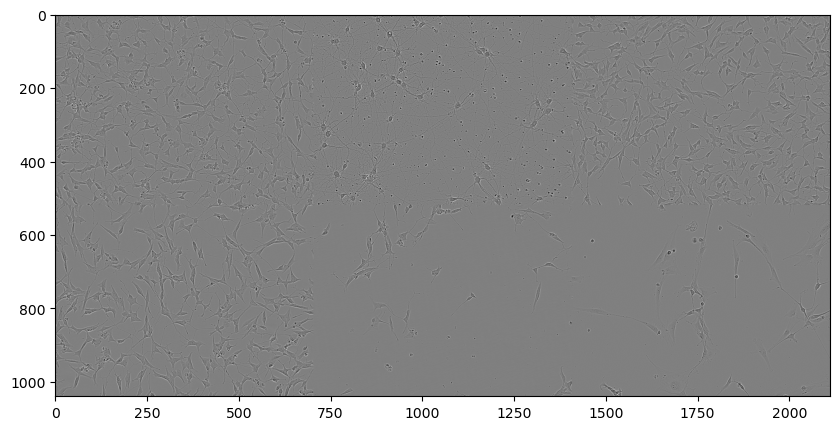

In [6]:
if RUN_EDA:
    img_names = Path(DATA_DIR+'train/').glob('*.png')
    img_list = []
    for i, img_name in enumerate(img_names):
        img_list.append(load_img(img_name.as_posix()))
        print(img_name.name)
        if i == 5: 
            break
    plt.figure(figsize=(10,10))
    plt.imshow(create_gallery(np.array(img_list), ncols=3))
else:
    print('RUN_EDA is False')

### Plot Mask

Let's see an example of mask images.

As mentioned earlier, mask images are often encoded using the RLE format, and thus it is necessary to decode them.

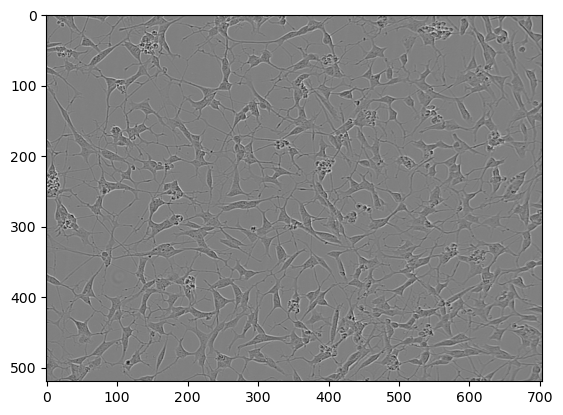

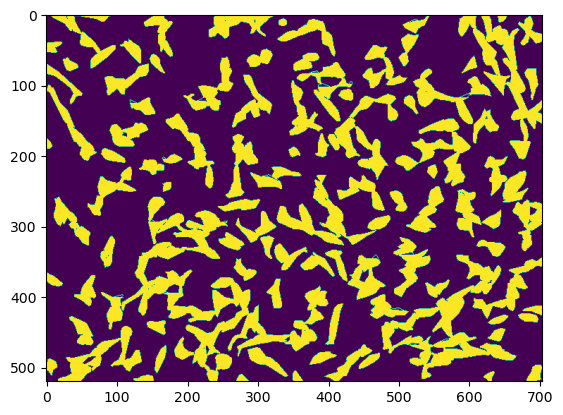

In [7]:
if RUN_EDA:
    image_id = grouped_df['id'][0]
    img = load_img(f'{DATA_DIR}train/{image_id}.png')
    masks = df[df['id'] == image_id]['annotation'].tolist()
    masked_img = create_mask_image(img, masks)
    plt.figure()
    plt.imshow(img)
    plt.figure()
    plt.imshow(masked_img)
else:
    print('RUN_EDA is False')

### Check Image Shape

Examining the size and color of the images in the dataset is another crucial step.

Generating histograms may also provide useful insights.

In [8]:
if RUN_EDA:
    img_shape = set()
    img_ext = set()
    img_names = Path(DATA_DIR+'train/').glob('*')
    pbar = tqdm(img_names, total=len(grouped_df))
    for img_name in pbar:
        img = load_img(img_name.as_posix())
        img_shape.add(img.shape)
        img_ext.add(img_name.suffix)
    print(f'Image shapes are {img_shape}.')
    print(f'Image extensions are {img_ext}.')

  0%|          | 0/606 [00:00<?, ?it/s]

Image shapes are {(520, 704, 3)}.
Image extensions are {'.png'}.


We are confident that all images are 520 x 704 RGB png.

### Plot histogram of pixel values

Generating a pixel value histogram can aid in identifying outlier images, such as those containing entirely zero-valued pixels.

  0%|          | 0/606 [00:00<?, ?it/s]

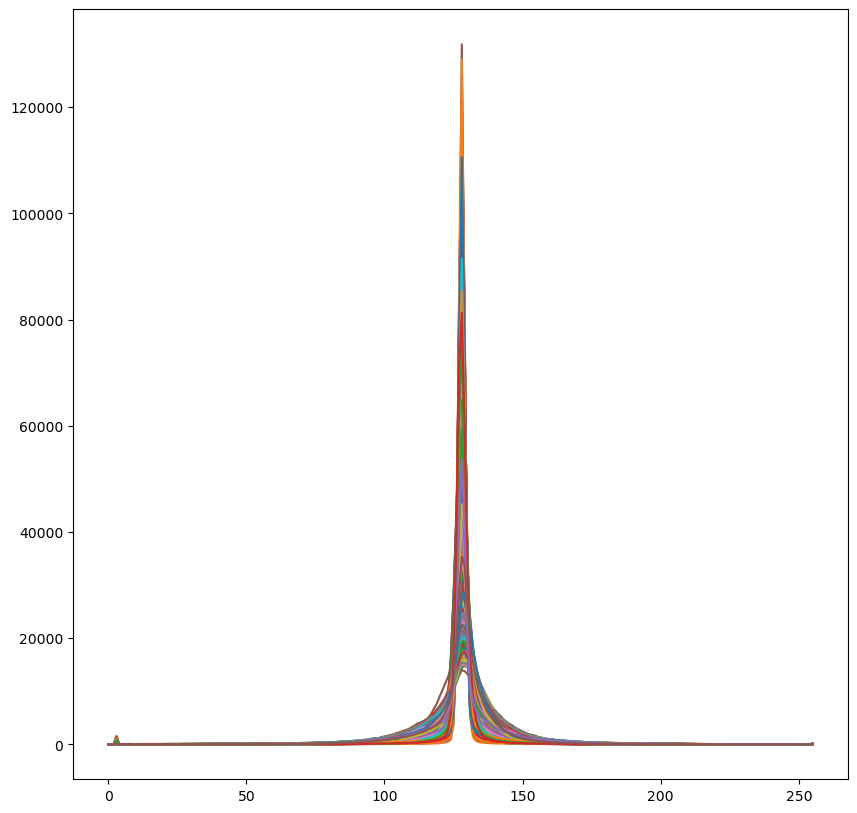

In [9]:
if RUN_EDA:
    img_names = Path(DATA_DIR+'train/').glob('*')
    plt.figure(figsize=(10,10))
    pbar = tqdm(img_names, total=len(grouped_df))
    for img_name in pbar:
        img = load_img(img_name.as_posix())
        hist = cv2.calcHist([img],[0],None,[256],[0,256])
        plt.plot(hist)
    plt.show()
else:
    print('RUN_EDA is False')

The image signals appear to be quite uniform, which is characteristic of typical microscopy images. :)

## Define Model Components

Before training a model using PyTorch, the following steps need to be completed:

1. Define Image Transformation and Augmentation
2. Define the Dataset
3. Define the DataLoader
4. Define the Model

### Define Image Transformation and Augmentation

**For segmentation tasks, the segmentation masks also need to undergo transformations and augmentations.**

Please also see [Albumentations Documentation/Mask augmentation for segmentation](https://albumentations.ai/docs/getting_started/mask_augmentation/). In this notebook, transforms are applied in the `CellDataset()` class.

In [10]:
# Image Transformation & Augmentation
def transform_train():
    transforms = [
        A.Resize(256,256,p=1),
        A.HorizontalFlip(p=0.5),
        A.Transpose(p=0.5),
        ToTensorV2(p=1)
    ]
    return A.Compose(transforms)


# Validation images undergo only resizing.
def transform_valid():
    transforms = [
        A.Resize(256,256,p=1),
        ToTensorV2(p=1)
    ]
    return A.Compose(transforms)

### Define Datasets

In [11]:
# Dataset
class CellDataset(Dataset):
    def __init__(self, image_ids, dataframe, data_root, transforms=None, stage='train'):
        super().__init__()
        self.image_ids = image_ids
        self.dataframe = dataframe
        self.data_root = data_root
        self.transforms = transforms
        self.stage = stage

    def __len__(self):
        return self.image_ids.shape[0]
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        # Load images
        image  = load_img(f'{self.data_root}{image_id}.png').astype(np.float32)

        # 3 channels to 1 channel
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image /= 255.0 # normalization

        # For training and validation
        if self.stage == 'train':
            # masks
            masks = self.dataframe[self.dataframe['id'] == image_id]['annotation'].tolist()
            mask_image = create_mask_image(image, masks)

            # Transform images and masks
            if self.transforms:
                transformed = self.transforms(image=image, mask=mask_image)
                image, mask_image = transformed['image'], transformed['mask']
            return image, mask_image, image_id
        
        # For test
        else:
            # Transform images
            if self.transforms:
                image =self.transforms(image=image)['image']
            
            return image, image_id

### Define the DataLoader

In [12]:
# DataLoader
def create_dataloader(grouped_df, df, trn_idx, val_idx):
    train_ = grouped_df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = grouped_df.loc[val_idx,:].reset_index(drop=True)

    # Dataset
    train_datasets = CellDataset(train_['id'].to_numpy(), df, DATA_DIR+'train/', transforms=transform_train())
    valid_datasets = CellDataset(valid_['id'].to_numpy(), df, DATA_DIR+'train/', transforms=transform_valid())

    # Data Loader
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, multiprocessing_context='fork')
    valid_loader = DataLoader(valid_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    return train_loader, valid_loader

### Define the model

In this notebook, we will implement the U-Net architecture using PyTorch, without relying on pre-existing implementations or models.

In [13]:
class DoubleConv(nn.Module):
    """DoubleConv is a basic building block of the encoder and decoder components. 
    Consists of two convolutional layers followed by a ReLU activation function.
    """    
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.double_conv(x)
        return x


class Down(nn.Module):
    """Downscaling.
    Consists of two consecutive DoubleConv blocks followed by a max pooling operation.
    """    
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x


class Up(nn.Module):
    """Upscaling.
    Performed using transposed convolution and concatenation of feature maps from the corresponding "Down" operation.
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input tensor shape: (batch_size, channels, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
    

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        
        self.down4 = Down(512,1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = torch.sigmoid(x)
        return x

## Run Training

As we did in the previous notebooks, we will perform cross-validation to evaluate the settings and determine **the best combinations of architectures and hyperparameters**. 

To effectively track the model's performance, I recommend utilizing MLOps tools like [**MLFlow**](https://mlflow.org/).

**Before running the following cell, please set configs in the `Set Config` section: `RUN_TRAINING = True` and `TRAIN_ALL = ` as you want.**

==========Cross-Validation Fold 1==========
==========Epoch 1 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 1 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7528 - val_loss : 0.7029 / Exec time 0 min

==========Epoch 2 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 2 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6623 - val_loss : 0.6256 / Exec time 0 min

==========Epoch 3 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 3 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.5917 - val_loss : 0.5664 / Exec time 0 min

==========Epoch 4 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 4 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5365 - val_loss : 0.5201 / Exec time 0 min

==========Epoch 5 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 5 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.4940 - val_loss : 0.4836 / Exec time 0 min

==========Epoch 6 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 6 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.4591 - val_loss : 0.4548 / Exec time 0 min

==========Epoch 7 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 7 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.4321 - val_loss : 0.4314 / Exec time 0 min

==========Epoch 8 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 8 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4088 - val_loss : 0.4126 / Exec time 0 min

==========Epoch 9 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 9 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.3925 - val_loss : 0.3969 / Exec time 0 min

==========Epoch 10 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 10 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.3759 - val_loss : 0.3842 / Exec time 0 min

==========Epoch 11 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 11 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.3630 - val_loss : 0.3733 / Exec time 0 min

==========Epoch 12 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 12 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.3526 - val_loss : 0.3643 / Exec time 0 min

==========Epoch 13 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 13 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.3422 - val_loss : 0.3565 / Exec time 0 min

==========Epoch 14 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 14 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.3347 - val_loss : 0.3498 / Exec time 0 min

==========Epoch 15 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 15 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.3275 - val_loss : 0.3439 / Exec time 0 min

==========Epoch 16 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 16 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.3216 - val_loss : 0.3389 / Exec time 0 min

==========Epoch 17 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 17 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.3167 - val_loss : 0.3344 / Exec time 0 min

==========Epoch 18 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 18 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.3116 - val_loss : 0.3304 / Exec time 0 min

==========Epoch 19 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 19 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.3066 - val_loss : 0.3269 / Exec time 0 min

==========Epoch 20 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 20 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.3026 - val_loss : 0.3237 / Exec time 0 min

==========Cross-Validation Fold 2==========
==========Epoch 1 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 1 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6660 - val_loss : 0.6261 / Exec time 0 min

==========Epoch 2 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 2 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.5966 - val_loss : 0.5625 / Exec time 0 min

==========Epoch 3 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 3 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.5431 - val_loss : 0.5138 / Exec time 0 min

==========Epoch 4 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 4 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5021 - val_loss : 0.4758 / Exec time 0 min

==========Epoch 5 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 5 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.4693 - val_loss : 0.4455 / Exec time 0 min

==========Epoch 6 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 6 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.4429 - val_loss : 0.4204 / Exec time 0 min

==========Epoch 7 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 7 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.4214 - val_loss : 0.3996 / Exec time 0 min

==========Epoch 8 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 8 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4033 - val_loss : 0.3819 / Exec time 0 min

==========Epoch 9 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 9 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.3885 - val_loss : 0.3669 / Exec time 0 min

==========Epoch 10 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 10 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.3753 - val_loss : 0.3542 / Exec time 0 min

==========Epoch 11 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 11 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.3634 - val_loss : 0.3429 / Exec time 0 min

==========Epoch 12 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 12 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.3552 - val_loss : 0.3331 / Exec time 0 min

==========Epoch 13 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 13 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.3464 - val_loss : 0.3248 / Exec time 0 min

==========Epoch 14 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 14 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.3390 - val_loss : 0.3175 / Exec time 0 min

==========Epoch 15 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 15 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.3338 - val_loss : 0.3110 / Exec time 0 min

==========Epoch 16 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 16 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.3267 - val_loss : 0.3052 / Exec time 0 min

==========Epoch 17 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 17 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.3235 - val_loss : 0.2999 / Exec time 0 min

==========Epoch 18 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 18 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.3173 - val_loss : 0.2952 / Exec time 0 min

==========Epoch 19 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 19 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.3132 - val_loss : 0.2910 / Exec time 0 min

==========Epoch 20 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 20 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.3104 - val_loss : 0.2871 / Exec time 0 min

==========Cross-Validation Fold 3==========
==========Epoch 1 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 1 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7917 - val_loss : 0.7376 / Exec time 0 min

==========Epoch 2 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 2 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6925 - val_loss : 0.6511 / Exec time 0 min

==========Epoch 3 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 3 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6156 - val_loss : 0.5857 / Exec time 0 min

==========Epoch 4 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 4 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5570 - val_loss : 0.5360 / Exec time 0 min

==========Epoch 5 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 5 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.5114 - val_loss : 0.4969 / Exec time 0 min

==========Epoch 6 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 6 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.4754 - val_loss : 0.4658 / Exec time 0 min

==========Epoch 7 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 7 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.4457 - val_loss : 0.4404 / Exec time 0 min

==========Epoch 8 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 8 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4218 - val_loss : 0.4196 / Exec time 0 min

==========Epoch 9 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 9 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.4023 - val_loss : 0.4023 / Exec time 0 min

==========Epoch 10 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 10 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.3857 - val_loss : 0.3880 / Exec time 0 min

==========Epoch 11 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 11 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.3707 - val_loss : 0.3758 / Exec time 0 min

==========Epoch 12 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 12 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.3606 - val_loss : 0.3656 / Exec time 0 min

==========Epoch 13 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 13 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.3489 - val_loss : 0.3568 / Exec time 0 min

==========Epoch 14 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 14 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.3397 - val_loss : 0.3492 / Exec time 0 min

==========Epoch 15 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 15 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.3324 - val_loss : 0.3427 / Exec time 0 min

==========Epoch 16 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 16 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.3253 - val_loss : 0.3370 / Exec time 0 min

==========Epoch 17 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 17 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.3194 - val_loss : 0.3320 / Exec time 0 min

==========Epoch 18 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 18 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.3136 - val_loss : 0.3276 / Exec time 0 min

==========Epoch 19 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 19 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.3103 - val_loss : 0.3237 / Exec time 0 min

==========Epoch 20 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 20 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.3059 - val_loss : 0.3202 / Exec time 0 min

==========Cross-Validation Fold 4==========
==========Epoch 1 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 1 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6969 - val_loss : 0.6543 / Exec time 0 min

==========Epoch 2 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 2 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6187 - val_loss : 0.5892 / Exec time 0 min

==========Epoch 3 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 3 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.5587 - val_loss : 0.5405 / Exec time 0 min

==========Epoch 4 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 4 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5124 - val_loss : 0.5028 / Exec time 0 min

==========Epoch 5 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 5 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.4755 - val_loss : 0.4729 / Exec time 0 min

==========Epoch 6 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 6 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.4466 - val_loss : 0.4492 / Exec time 0 min

==========Epoch 7 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 7 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.4218 - val_loss : 0.4298 / Exec time 0 min

==========Epoch 8 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 8 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4030 - val_loss : 0.4138 / Exec time 0 min

==========Epoch 9 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 9 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.3868 - val_loss : 0.4007 / Exec time 0 min

==========Epoch 10 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 10 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.3730 - val_loss : 0.3895 / Exec time 0 min

==========Epoch 11 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 11 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.3607 - val_loss : 0.3801 / Exec time 0 min

==========Epoch 12 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 12 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.3512 - val_loss : 0.3721 / Exec time 0 min

==========Epoch 13 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 13 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.3425 - val_loss : 0.3652 / Exec time 0 min

==========Epoch 14 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 14 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.3358 - val_loss : 0.3592 / Exec time 0 min

==========Epoch 15 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 15 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.3278 - val_loss : 0.3540 / Exec time 0 min

==========Epoch 16 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 16 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.3227 - val_loss : 0.3494 / Exec time 0 min

==========Epoch 17 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 17 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.3171 - val_loss : 0.3453 / Exec time 0 min

==========Epoch 18 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 18 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.3138 - val_loss : 0.3416 / Exec time 0 min

==========Epoch 19 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 19 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.3084 - val_loss : 0.3384 / Exec time 0 min

==========Epoch 20 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 20 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.3047 - val_loss : 0.3354 / Exec time 0 min

==========Cross-Validation Fold 5==========
==========Epoch 1 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 1 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7361 - val_loss : 0.6936 / Exec time 0 min

==========Epoch 2 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 2 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6540 - val_loss : 0.6169 / Exec time 0 min

==========Epoch 3 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 3 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.5897 - val_loss : 0.5572 / Exec time 0 min

==========Epoch 4 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 4 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5404 - val_loss : 0.5099 / Exec time 0 min

==========Epoch 5 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 5 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.5006 - val_loss : 0.4722 / Exec time 0 min

==========Epoch 6 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 6 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.4689 - val_loss : 0.4413 / Exec time 0 min

==========Epoch 7 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 7 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.4436 - val_loss : 0.4162 / Exec time 0 min

==========Epoch 8 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 8 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4226 - val_loss : 0.3950 / Exec time 0 min

==========Epoch 9 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 9 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.4056 - val_loss : 0.3777 / Exec time 0 min

==========Epoch 10 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 10 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.3909 - val_loss : 0.3627 / Exec time 0 min

==========Epoch 11 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 11 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.3782 - val_loss : 0.3503 / Exec time 0 min

==========Epoch 12 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 12 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.3683 - val_loss : 0.3393 / Exec time 0 min

==========Epoch 13 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 13 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.3592 - val_loss : 0.3297 / Exec time 0 min

==========Epoch 14 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 14 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.3514 - val_loss : 0.3212 / Exec time 0 min

==========Epoch 15 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 15 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.3451 - val_loss : 0.3140 / Exec time 0 min

==========Epoch 16 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 16 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.3396 - val_loss : 0.3074 / Exec time 0 min

==========Epoch 17 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 17 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.3348 - val_loss : 0.3017 / Exec time 0 min

==========Epoch 18 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 18 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.3280 - val_loss : 0.2964 / Exec time 0 min

==========Epoch 19 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 19 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.3236 - val_loss : 0.2916 / Exec time 0 min

==========Epoch 20 Start Training==========


  0%|          | 0/61 [00:00<?, ?it/s]

==========Epoch 20 Start Validation==========


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.3219 - val_loss : 0.2874 / Exec time 0 min



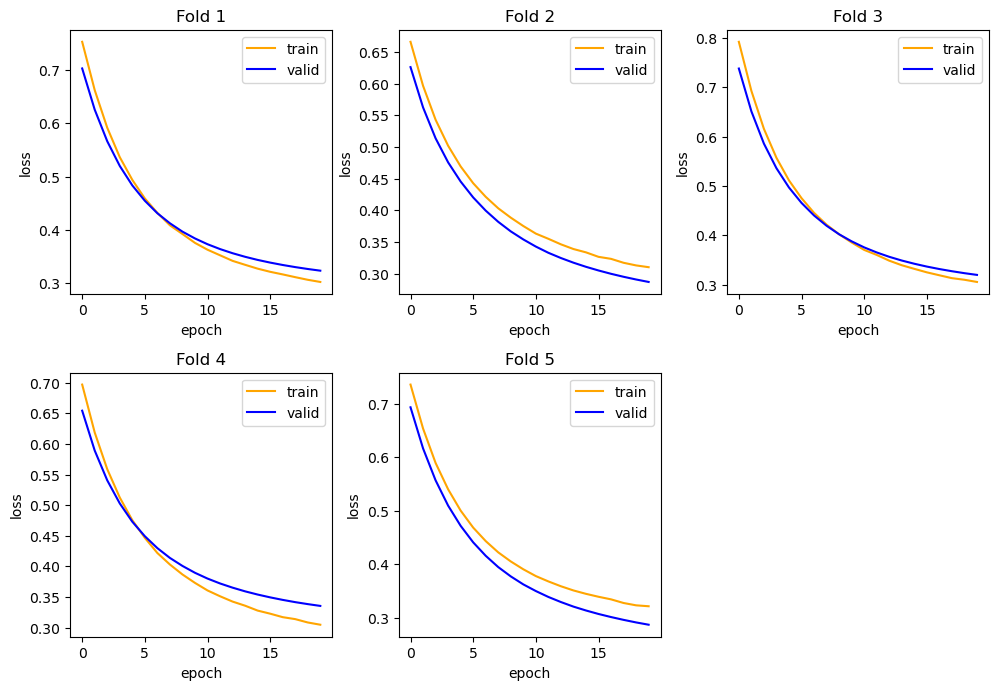

In [14]:
if RUN_TRAINING:
    if TRAIN_ALL:
        # Train with all data
        folds = [['','']]
    else: 
        # Cross-validation
        folds = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)\
                .split(np.arange(grouped_df.shape[0]), grouped_df['id'].to_numpy())
        
        # For Visualization
        train_loss_list = []
        valid_loss_list = []
    

    for fold, (trn_idx, val_idx) in enumerate(folds):
        # Load Data   
        if TRAIN_ALL:
            train_datasets = CellDataset(grouped_df['id'].to_numpy(), df, DATA_DIR+'train/', transforms=transform_train())
            train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, multiprocessing_context='fork')
        else:
            print(f'==========Cross-Validation Fold {fold+1}==========')   
            train_loader, valid_loader = create_dataloader(grouped_df, df, trn_idx, val_idx)
            # For Visualization
            valid_losses = []

        train_losses = []
        # Load model, loss function, and optimizing algorithm
        model = UNet().to(device)
        criterion = nn.BCELoss().to(device)
        optimizer = optim.SGD(model.parameters(), weight_decay=WEIGHT_DECAY, lr = LR, momentum=MOMENTUM)
        
        # Start training
        best_loss = 10**5
        for epoch in range(EPOCHS):
            time_start = time.time()
            print(f'==========Epoch {epoch+1} Start Training==========')
            model.train()
            train_loss = 0
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for step, (imgs, masks, image_ids) in pbar:
                imgs = imgs.to(device).float()
                # imgs = torch.squeeze(imgs)
                masks = masks.to(device).float()
                masks = masks.view(imgs.shape[0], -1, 256, 256)

                optimizer.zero_grad()
                
                output = model(imgs)
                loss = criterion(output, masks)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            train_loss /= len(train_loader)

            # Validation
            if TRAIN_ALL == False:
                print(f'==========Epoch {epoch+1} Start Validation==========')
                
                with torch.no_grad():
                    valid_loss = 0
                    preds = []
                    pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
                    for step, (imgs, masks, image_ids) in pbar:
                        imgs = imgs.to(device).float()
                        # imgs = torch.squeeze(imgs)
                        masks = masks.to(device).float()
                        masks = masks.view(imgs.shape[0], -1, 256, 256)
                
                        val_output = model(imgs)
                        val_loss = criterion(val_output, masks)
                        
                        valid_loss += val_loss.item()
                    valid_loss /= len(valid_loader)
                    
            # print results from this epoch
            exec_t = int((time.time() - time_start)/60)
            if TRAIN_ALL:
                print(f'Epoch : {epoch+1} - loss : {train_loss:.4f} / Exec time {exec_t} min\n')

            else:
                print(
                    f'Epoch : {epoch+1} - loss : {train_loss:.4f} - val_loss : {valid_loss:.4f} / Exec time {exec_t} min\n'
                )
                # For visualization
                train_losses.append(train_loss)
                valid_losses.append(valid_loss)
        
        if TRAIN_ALL:
            print(f'Save model trained with all data')
            os.makedirs(MODEL_DIR, exist_ok=True)
            torch.save(model.state_dict(), MODEL_DIR+'segmentation.pth')
            del model, optimizer, train_loader
        else:
            train_loss_list.append(train_losses)
            valid_loss_list.append(valid_losses)
            del model, optimizer, train_loader, valid_loader, train_losses, valid_losses
        gc.collect()
        torch.cuda.empty_cache()
    
    if TRAIN_ALL == False:
        show_validation_score(train_loss_list, valid_loss_list)

else:
    print('RUN_TRAINING is False')

Although the learning has not yet converged, we will move on to the next step.

Run this cell again with the `TRAIN_ALL` parameter set to `True` to obtain the `.pth` file.

## Run Inference of Test Data

In this task, the same Dataset, Image transformation, and model as we used for validation. So no need to define new functions.

**Before running the following cells, please set `RUN_INFERENCE = True` in the `Set Config` section.**

In [15]:
if RUN_INFERENCE:
    files = os.listdir(DATA_DIR+'test/')
    image_ids = np.array([os.path.splitext(file)[0] for file in files])
    ids = []
    rle_test_preds = []
    original_size = (704, 520) # (width, height)

    # Load Data
    test_datasets = CellDataset(image_ids, df, DATA_DIR+'test/', transforms=transform_valid(), stage='test')

    # Data Loader
    test_loader = DataLoader(test_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    # Load model, loss function, and optimizing algorithm
    model = UNet().to(device)
    model.load_state_dict(torch.load(MODEL_DIR+'segmentation.pth'))
       
    # Start Inference
    print(f'==========Start Inference==========')
    with torch.no_grad():
        test_preds = []
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, (imgs, image_ids) in pbar:
            imgs = imgs.to(device).float()
            output = model(imgs)

            # Convert the output from PyTorch to np.array
            output = output.detach().cpu().numpy()
            
            # run length encoding
            for image_id, predicted_mask in zip(image_ids, output):
                predicted_mask = np.squeeze(predicted_mask)
                
                # resize
                predicted_mask = cv2.resize(predicted_mask, original_size)
                
                rle_mask = encode_rle(predicted_mask)
                ids.append(image_id)
                rle_test_preds.append(rle_mask)
    
    submission_df = pd.DataFrame({
        'id': ids, 'predicted': rle_test_preds
    })
    print(submission_df.head())

else:
    print('RUN_INFERENCE is False')

RUN_INFERENCE is False


### Visualize One prediction example

Let's see one output example at the current threshold. In practice, the output results are compared at various thresholds to select the threshold with the best evaluation metrics.

In [ ]:
if RUN_INFERENCE:
    plt.imshow(predicted_mask > THRESHOLD)
else:
    print('RUN_INFERENCE is False')

### Save inference result

In [ ]:
if RUN_INFERENCE:
    if KAGGLE:
        submission_df.to_csv('submission.csv', index=False)
    else:
        submission_df.to_csv(CSV_SAVE_DIR+f'segmentation_test.csv')

else:
    print('RUN_INFERENCE is False')

## Visualize one submission example

This confirms whether the output style is correct.

In [ ]:
if RUN_INFERENCE:
    target = submission_df.iloc[0]
    img = load_img(f'{DATA_DIR}test/{target["id"]}.png')
    masks = [target['predicted']]
    masked_img = create_mask_image(img, masks)
    plt.figure()
    plt.imshow(img)
    plt.figure()
    plt.imshow(masked_img)

else:
    print('RUN_INFERENCE is False')

## To Improve the Model



- **Preprocess input images**
    - Variety of augmentation such as flipping, rotating, and scaling the images.
- **Optimize the model**
    - A larger and more diverse training dataset
    - Experimenting with different architectures and hyperparameters
    - Experiment with different architectures and hyperparameters
    - Choosing an appropriate Loss function, such as Dice Loss
- **Modify the model output**
    - Finding the best threshold
    - Using an ensemble of models
    - Postprocessing

By implementing these techniques, it's possible to build a highly accurate semantic segmentation model.

I trust that this notebook provided you with useful information for building an semantic segmentation model. Wishing you success in all your future modeling projects!

## Acknowledgement

I thank to [Matchan from YouTube Channel - Engawa AI Research Institute](https://www.youtube.com/channel/UCRwO-ewBHhNiC4qBEppi_JQ), Mr. Masaaki Aiba, and [Mr. Yuto Shinahara](https://twitter.com/snhrytdesu) for valuable discussion.

## References

- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) ... original papaer of U-Net
- [PyTorch](https://pytorch.org/)
	- [PyTorch - SAVING AND LOADING MODELS](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
- [OpenCV](https://opencv.org/)
- [scikit-image](https://scikit-image.org/)
- [MLFlow](https://mlflow.org/) 
- [Albumentations Documentation/Mask augmentation for segmentation](https://albumentations.ai/docs/getting_started/mask_augmentation/)
- [Kaggle Sartorius - Cell Instance Segmentation competition](https://www.kaggle.com/competitions/sartorius-cell-instance-segmentation/overview)
- [Kaggle - I dont get the discription of the expression of defect pixels](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/102311)
